# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Подготовка данных

Настройка ширины ячейки и загрузка необходимых библиотек

In [18]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score

## Импорт данных, приведение типов, визуализация распределений

Импорт данных

In [19]:
df=pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- Отмечаем, что 10% значений для параметра tenure (сколько лет человек является клиентом банка) отсутстуют. В остальном данные полные
- Типы данных адекватны, однако значениям tenure (как показал дальнейший анализ) следует присвоить целочисленный тип

In [21]:
df['Tenure']=df['Tenure'].astype('Int64')

- Убираем столбцы, которые не нужны для построения модели

In [22]:
df=df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Приводим имена столбцов к стандартному виду

In [23]:
df.columns=df.columns.str.lower()

Визуализируем оставшиеся данные для анализа их распределений:

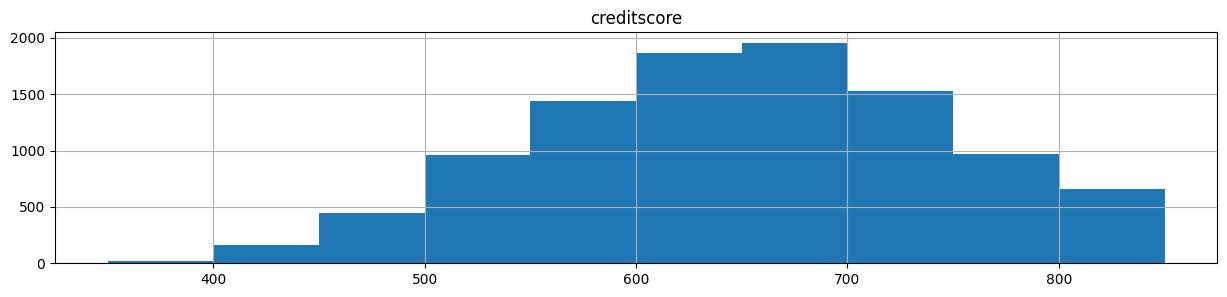

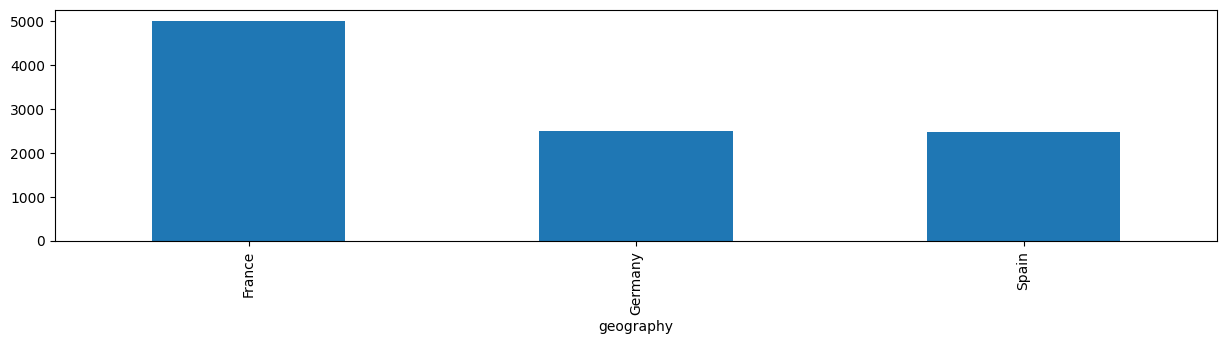

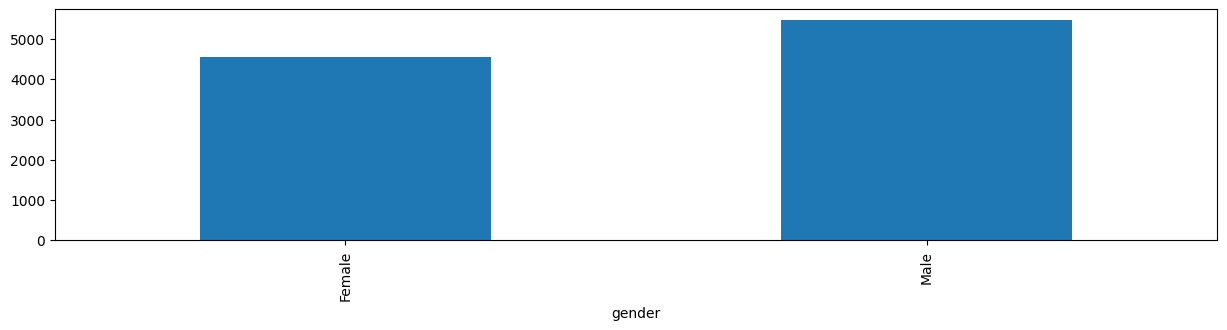

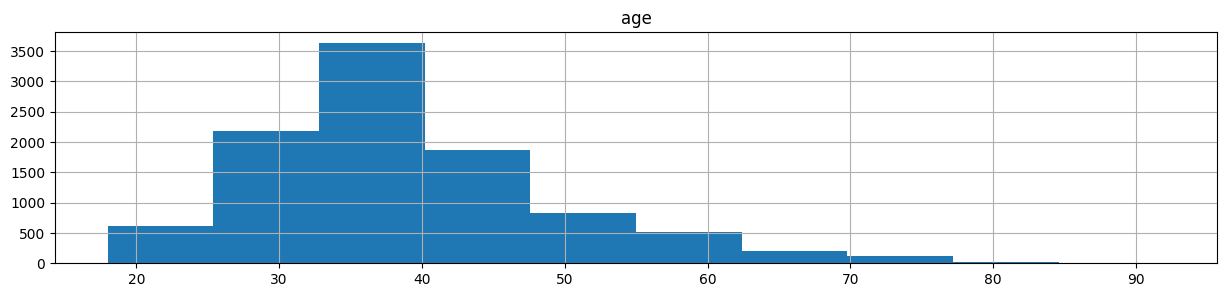

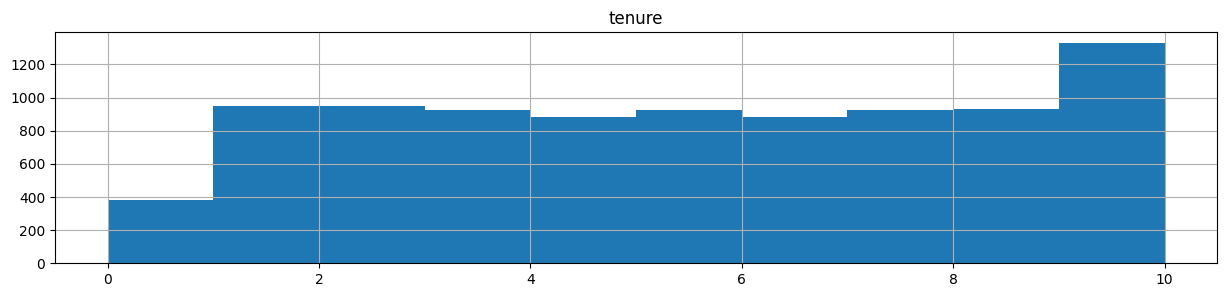

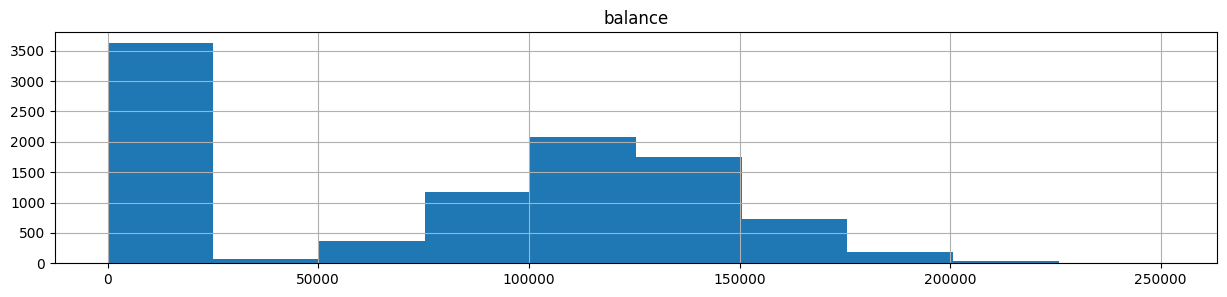

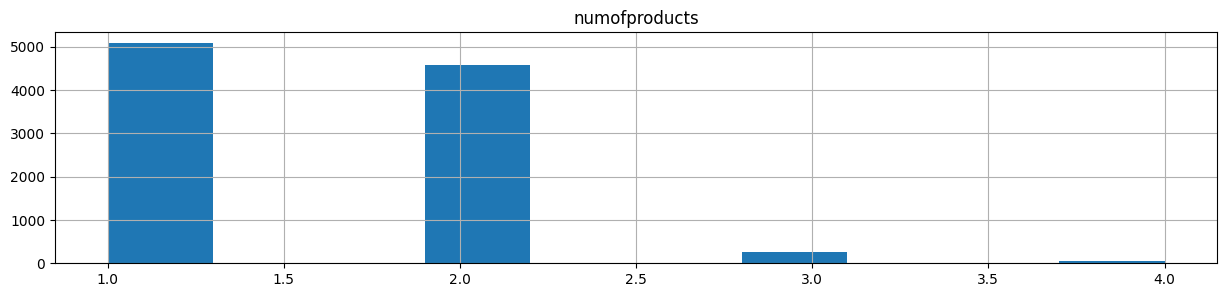

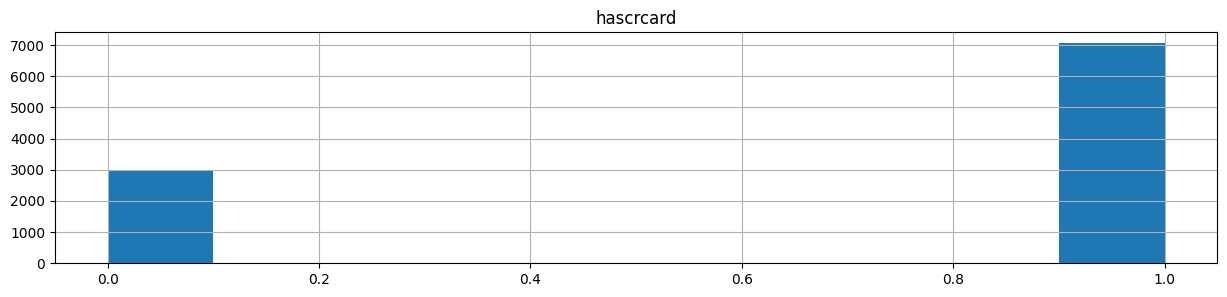

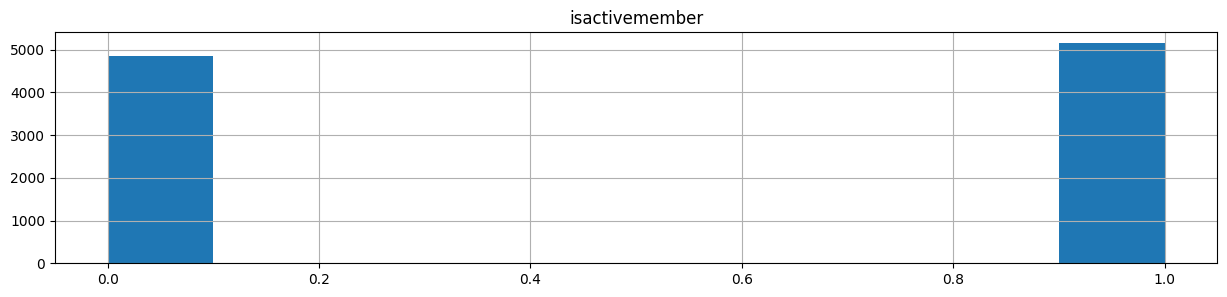

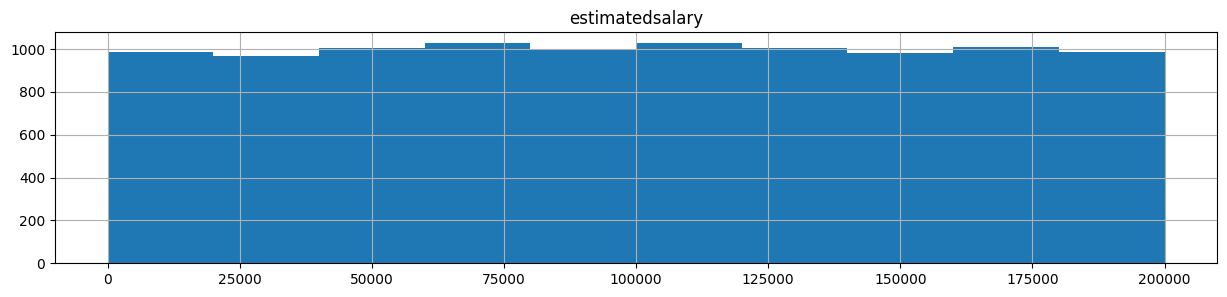

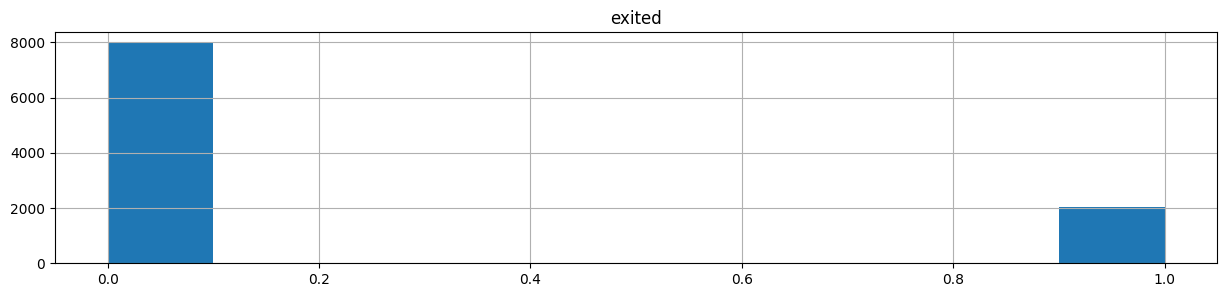

In [24]:
for column in df.columns:
    if df[column].dtype != 'object':
        df.hist(column=column, figsize = (15,3))
        plt.show()
    else:
        df.groupby (column)[column].count().plot(y=column, kind='bar', figsize = (15,3));
        plt.show()

Входные данные выглядят адекватно. При этом
1) отмечается дисбаланс классов целевого признака (доля ушедших клиентов - около 20%)
2) необходимо доп. исследование параметра tenure

Распределение tenure характеризуется относительно редкими значениями 0. Его необходимо исследовать дополнительно, тк это может помочь верно заполнить пропуски - возможно, есть основание присвоить пропущенным данным значение 0.

## Доп. исследование параметра tenure

Сопоставим распределение других параметров при наличии и отсутствии значений в столбце tenure

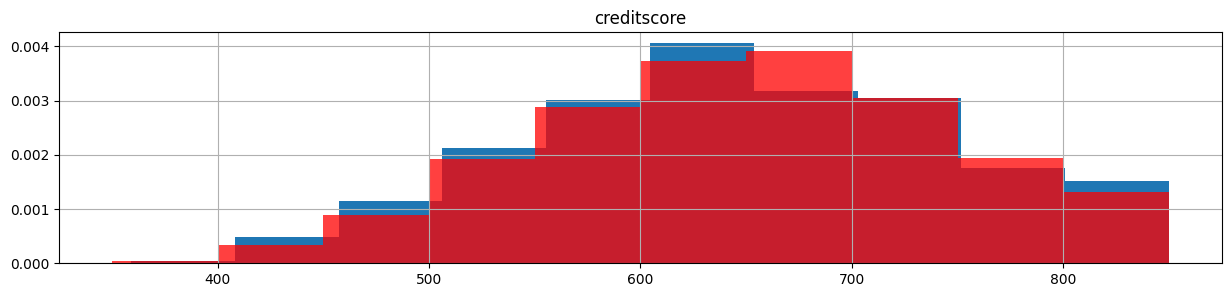

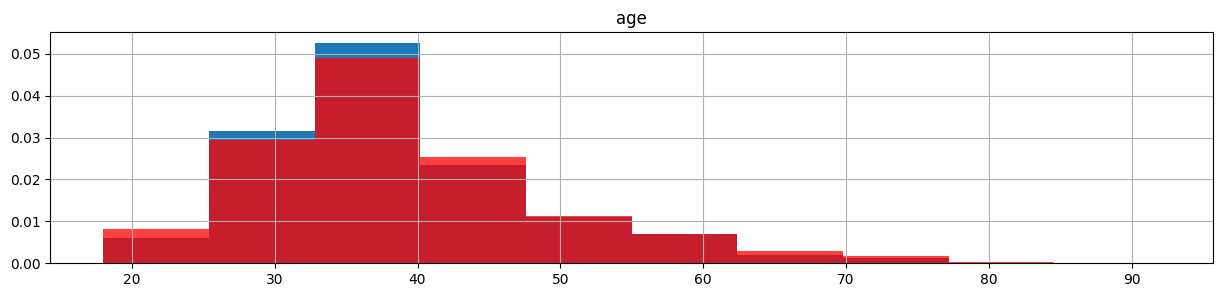

/home/sergey/anaconda3/envs/yp/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


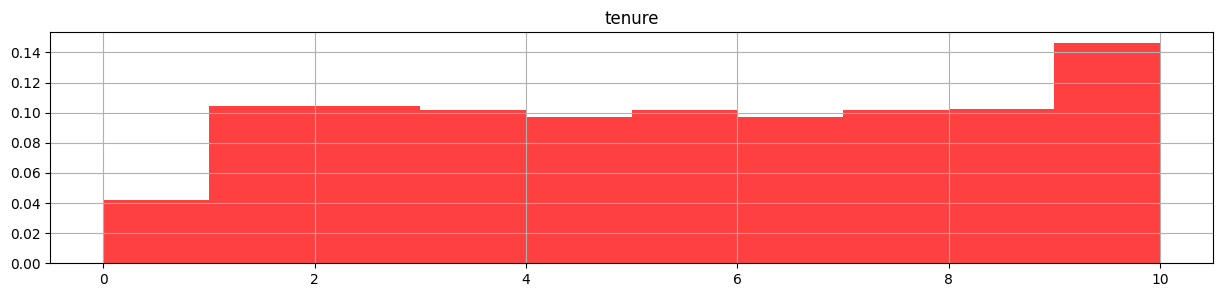

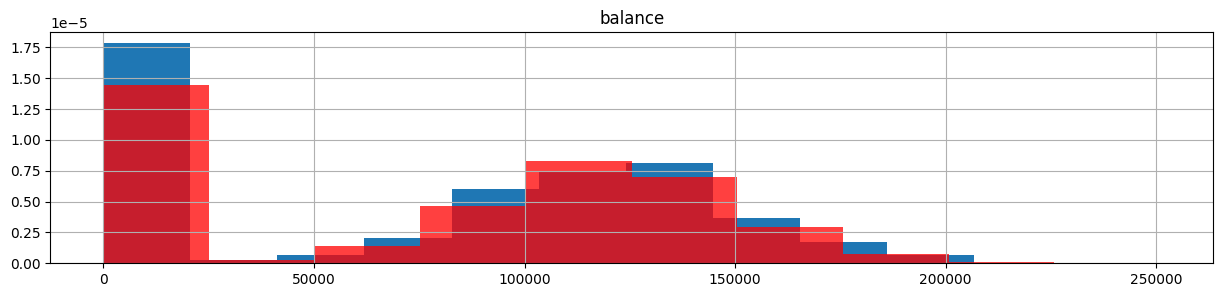

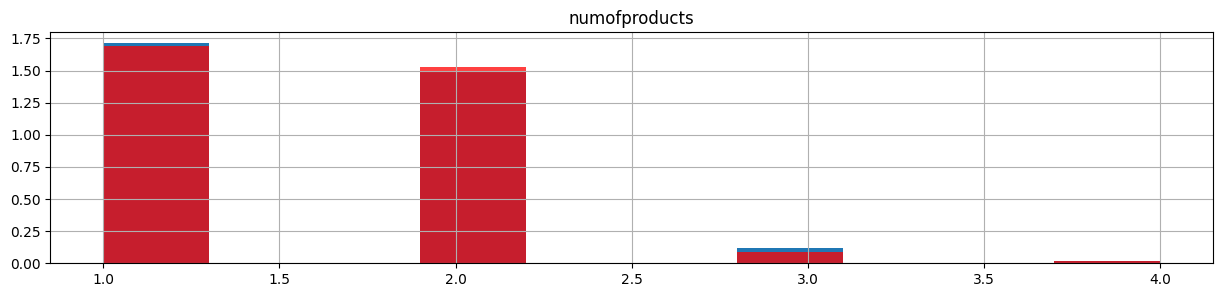

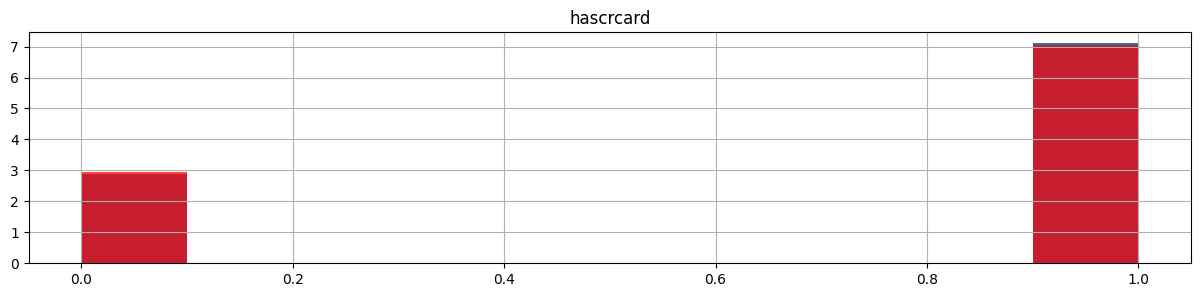

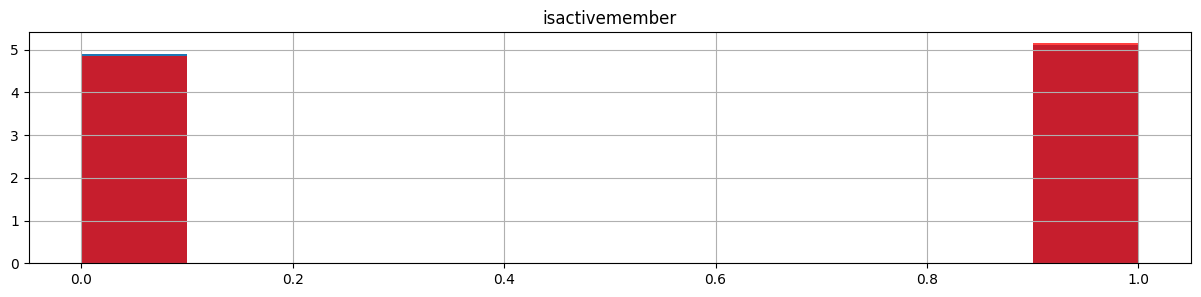

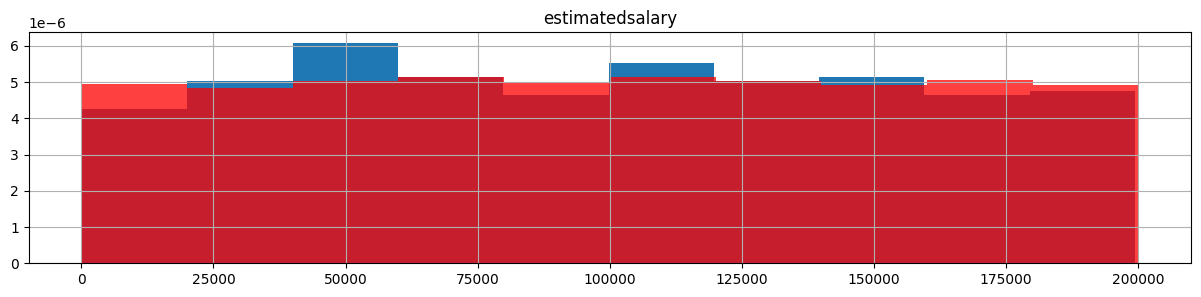

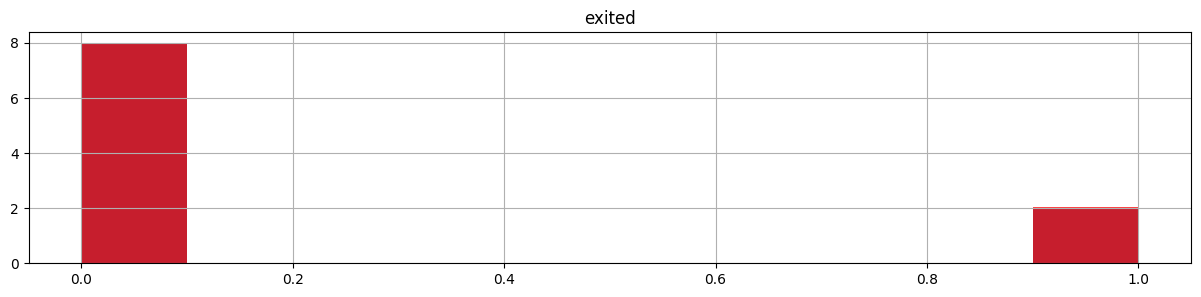

In [25]:
df2=df[df['tenure'].isna()]
for column in df.columns:
    if df[column].dtype != 'object':
        ax=df2.hist(column=column, figsize = (15,3), density=True)
        df.hist(column=column, figsize = (15,3), ax=ax, alpha=0.75, density=True, color = 'r')
        plt.show()

Видно, что распределения близки

Из расчетов ниже видно, что:
- Параметр принимает дискретное значение от 0 до 10, причем нулей почти троекратно меньше, чем других значений
- Пропусков 900. Если все пропуски заполнить 0, это значительно изменит распределение

In [26]:
df.groupby('tenure')['tenure'].count()

tenure
0     382
1     952
2     950
3     928
4     885
5     927
6     881
7     925
8     933
9     882
10    446
Name: tenure, dtype: int64

In [27]:
df['tenure'].isna().sum()

909

- Согласно проведенному анализу оснований для присвоения пропущенным значениям столбца tenure значения 0 или другого отличного от медианы значения нет
- В идеале, для принятия информированного решения необходимо вернуться к инженерам, подготовившим входные данные и уточнить причины отсутствия параметров, а также адекватность низкой частоты величины tenure 0 (действительно ли новые клиенты стали реже появляться в последний год?)
- За неимением такой возможности в данной задаче заменяем пропущенные значения медианным

0


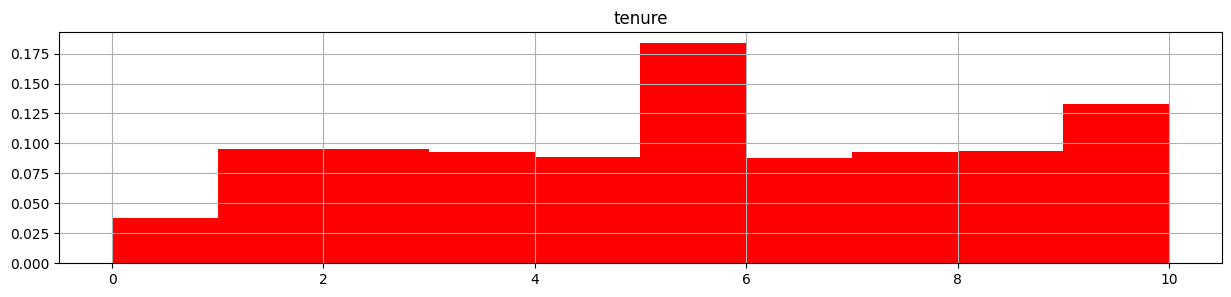

In [28]:
df.loc[df['tenure'].isna(),'tenure']=df['tenure'].median();
print(df['tenure'].isna().sum())
df.hist(column='tenure', figsize = (15,3), density=True, color = 'r');

## Подготавливаем категорийные признаки через OHE

При этом избегаем dummy error и удаляем обработанные OHE столбцы

In [29]:
df=df.join(pd.get_dummies(df['geography'], drop_first=True))

In [30]:
df=df.join(pd.get_dummies(df['gender'], drop_first=True))

In [31]:
df=df.drop(columns=['geography', 'gender'])
df

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


## Scaling

## Выводы по подготовке данных

- Данные полные за исключением параметра tenure (сколько лет человек является клиентом банка), для которого отсутствуют 10% значений
- Типы данных адекватны, однако столбцу tenure следует присвоить целочисленный тип
- Столбцы, которые не нужны для построения модели, убраны. Имена остальных столбцов приведены к стандартному виду
- Визуализация распределения входные данные подтверждает их адекватность. При этом
    - отмечается дисбаланс классов целевого признака (доля ушедших клиентов - около 20%)
    - распределение параметра tenure исследовано дополнительно
- Согласно проведенному анализу оснований для присвоения пропущенным значениям столбца tenure значения 0 или другого отличного от медианы значения нет. В идеале, для принятия информированного решения необходимо вернуться к инженерам, подготовившим входные данные и уточнить причины отсутствия параметров, а также адекватность низкой частоты величины tenure 0. За неимением такой возможности в данной задаче пропущенные значения заменены медианным
- Категорийные признаки (gender, geography) подготовили через OHE. При этом избежали dummy error и удалили обработанные OHE столбцы
 

# Исследование задачи

Баданс классов исследован выше. Найдем оптимальную модель без учета дисбаланса классов

# Борьба с дисбалансом

# Тестирование модели

# Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*